In [1]:
import numpy as np
import mne # docu: https://mne.tools/stable/overview/index.html
import pandas as pd
import matplotlib.pyplot as plt
import glob
import mne_connectivity as mne_connect
from autoreject import get_rejection_threshold
from mne.preprocessing import EOGRegression

# https://neuraldatascience.io/7-eeg/mne_data.html
%matplotlib widget

### Načtení dat

In [20]:
raw = mne.io.read_raw_eximia("../data_ukazka/sub-S05/sub-S05.nxe", preload=True, verbose=None)
raw.set_montage('standard_1005')

Loading sub-S05.nxe
Reading 0 ... 1163655  =      0.000 ...   802.521 secs...


<RawEximia | sub-S05.nxe, 64 x 1163656 (802.5 s), ~568.3 MB, data loaded>

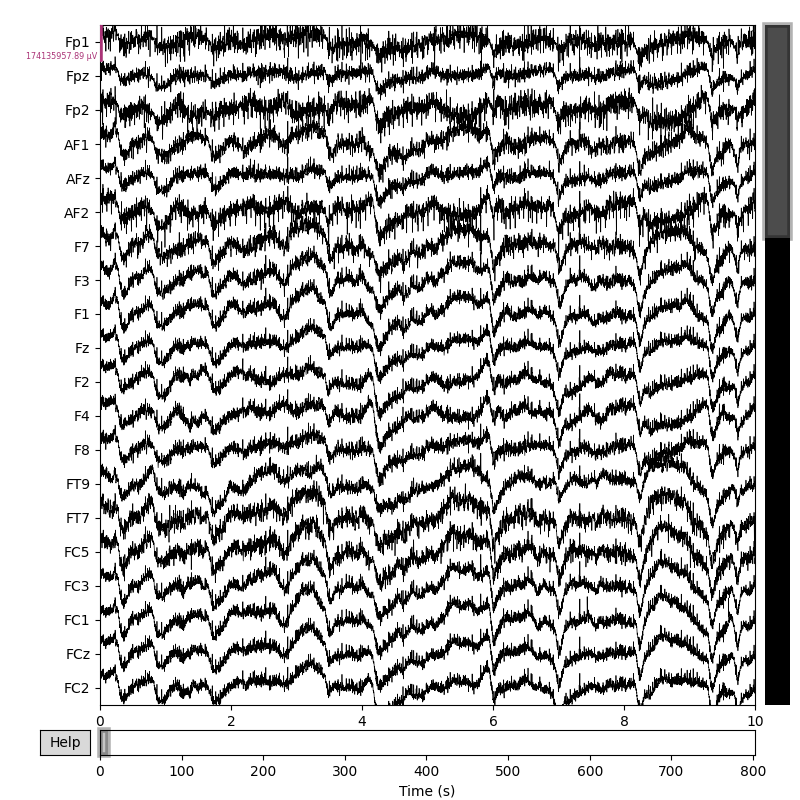

In [21]:
raw.plot(scalings='auto');

### Band-pass filtering

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 47851 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Effective window size : 1.412 (s)


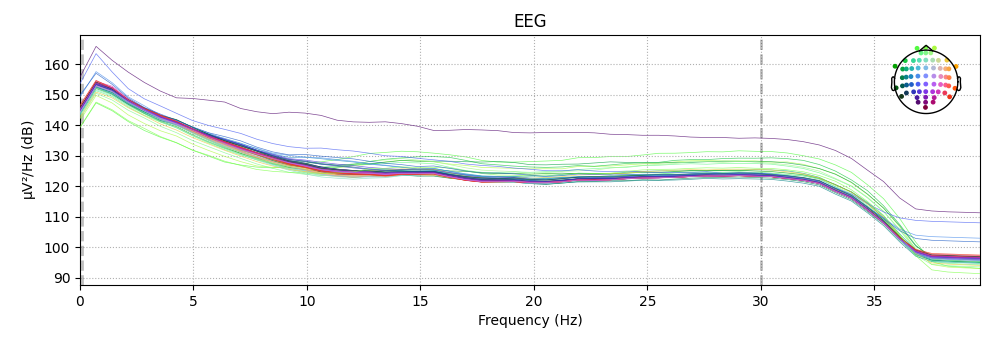

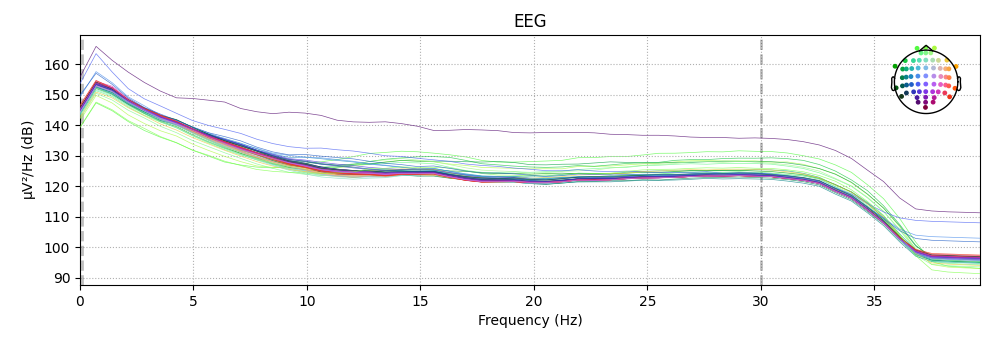

In [22]:
# Removing slow drifts makes for more stable regression coefficients. Make sure
# to apply the same filter to both EEG and EOG channels!

# Filter settings
low_cut = 0.1
hi_cut  = 30

raw_filtered = raw.filter(low_cut, hi_cut,picks=['eeg','eog'])
raw_filtered.compute_psd(fmax=40).plot();

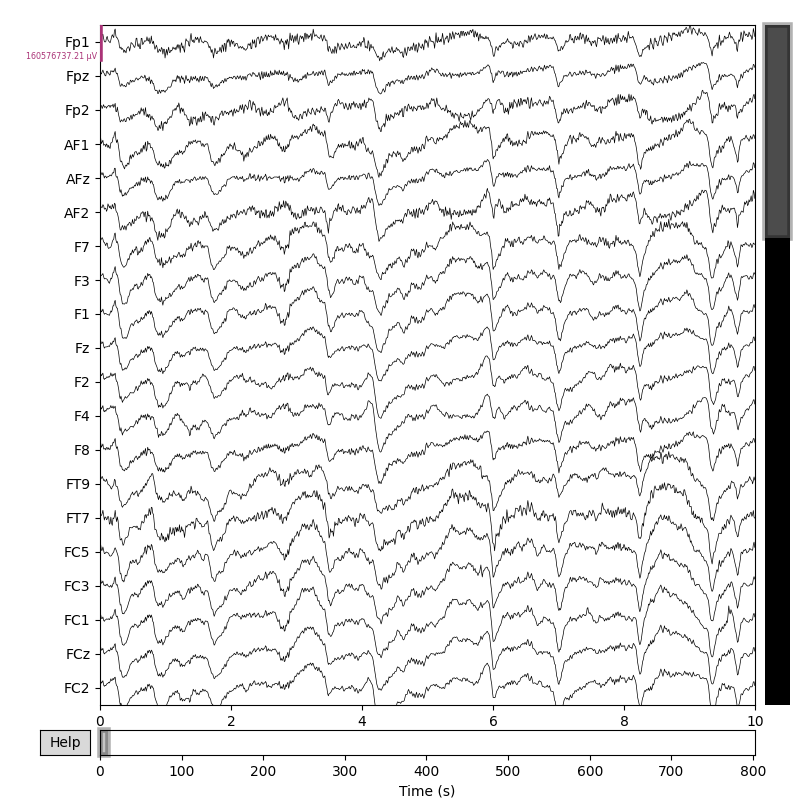

In [23]:
raw_filtered.plot(scalings='auto');

### Anotace, epochy

In [24]:
events = mne.find_events(raw_filtered, stim_channel=["GateIn","Trig1","Trig2"],min_duration = 2 / raw_filtered.info['sfreq'])


331 events found
Event IDs: [4]


In [25]:
mapping = {
    4: "trigger",
}
annot_from_events = mne.annotations_from_events(
    events=events,
    event_desc=mapping,
    sfreq=raw_filtered.info["sfreq"],
    orig_time=raw_filtered.info["meas_date"],
)
raw_filtered.set_annotations(annot_from_events)
raw_filtered.annotations

<Annotations | 331 segments: trigger (331)>

In [26]:
# Epoching settings
tmin =  -.200  # start of each epoch (in sec)
tmax =  1.000  # end of each epoch (in sec)
baseline = (None, 0)

# Create epochs
events, event_dict = mne.events_from_annotations(raw_filtered)
epochs = mne.Epochs(raw_filtered,
                    events, event_dict,
                    tmin, tmax,
                    baseline=baseline, 
                    preload=True) 

Used Annotations descriptions: ['trigger']
Not setting metadata
331 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 331 events and 1741 original time points ...
0 bad epochs dropped


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


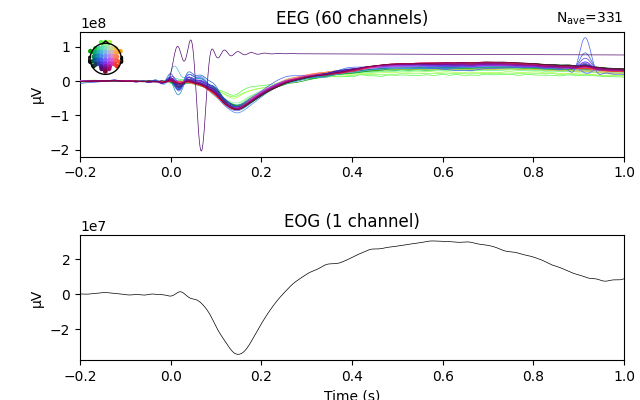

In [27]:
# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot() # https://mne.tools/stable/auto_tutorials/evoked/20_visualize_evoked.html

### EOG events
<https://mne.tools/stable/auto_tutorials/preprocessing/35_artifact_correction_regression.html#tut-artifact-regression>

In [10]:
# From tutorial:
# The regression technique works regardless of chosen reference. However, it is
# important to choose a reference before proceeding with the analysis.
raw_filtered.set_eeg_reference("average")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEximia | sub-S03.nxe, 64 x 943293 (650.5 s), ~460.7 MB, data loaded>

In [11]:
eog_events = mne.preprocessing.find_eog_events(raw_filtered,ch_name='EOG')
eog_events

Using EOG channel: EOG
EOG channel index for this subject is: [3]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 14500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 216 significant peaks
Number of EOG events detected: 216


array([[  5857,      0,    998],
       [ 12932,      0,    998],
       [ 16400,      0,    998],
       [ 18936,      0,    998],
       [ 26913,      0,    998],
       [ 30936,      0,    998],
       [ 39613,      0,    998],
       [ 40730,      0,    998],
       [ 42541,      0,    998],
       [ 45311,      0,    998],
       [ 48160,      0,    998],
       [ 48570,      0,    998],
       [ 51976,      0,    998],
       [ 63368,      0,    998],
       [ 69400,      0,    998],
       [ 73521,      0,    998],
       [ 80022,      0,    998],
       [ 87499,      0,    998],
       [ 88173,      0,    998],
       [ 97000,      0,    998],
       [ 97986,      0,    998],
       [ 99892,      0,    998],
       [109008,      0,    998],
       [112211,      0,    998],
       [120930,      0,    998],
       [134011,      0,    998],
       [149486,      0,    998],
       [156118,      0,    998],
       [158934,      0,    998],
       [163922,      0,    998],
       [16